# Collaborative Filtering for Movie Recommendations

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


https://www.kaggle.com/indralin/movielens-project-1-2-collaborative-filtering

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


## First, load the data and apply preprocessing


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


In [ ]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
f = open( movielens_dir / "README.txt", "r")
print(f.read())

First, need to perform some preprocessing to encode users and movies as integer indices.


In [ ]:
df['userId']

0           1
1           1
2           1
3           1
4           1
         ... 
100831    610
100832    610
100833    610
100834    610
100835    610
Name: userId, Length: 100836, dtype: int64

In [ ]:
df['user']

KeyError: ignored

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


## Prepare training and validation data


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train the model based on the data split


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/10
1418/1418 [==============================] - 10s 6ms/step - loss: 0.6361 - val_loss: 0.6205
Epoch 2/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6134 - val_loss: 0.6202
Epoch 3/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6087 - val_loss: 0.6151
Epoch 4/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6079 - val_loss: 0.6142
Epoch 5/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6075 - val_loss: 0.6119
Epoch 6/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6065 - val_loss: 0.6122
Epoch 7/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6055 - val_loss: 0.6114
Epoch 8/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6045 - val_loss: 0.6131
Epoch 9/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6053 - val_loss: 0.6136
Epoch 10/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.60

## Plot training and validation loss


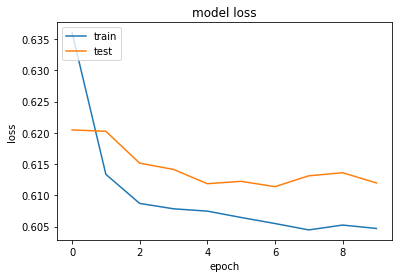

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


## Show top 10 movie recommendations to a user


In [ ]:
def emotion_label(emotion):
  if emotion == 0:
    return "Angry"
  elif emotion == 1:
    return "Disgust"
  elif emotion == 2:
    return "Fear"
  elif emotion == 3:
    return "Happy"
  elif emotion == 4:
    return "Sad"
  elif emotion == 5:
    return "Surprise"
  else:
    return "Neutral"

In [ ]:
def genre_label(genre_ids):
  genre_list = []
  for id in genre_ids:
    if id == 0:
      genre_list.append("Action")
    elif id == 1:
      genre_list.append("Adventure")
    elif id == 2:
      genre_list.append("Animation")
    elif id == 3:
      genre_list.append("Children's")
    elif id == 4:
      genre_list.append("Comedy")
    elif id == 5:
      genre_list.append("Crime")
    elif id == 6:
      genre_list.append("Documentary")
    elif id == 7:
      genre_list.append("Drama")
    elif id == 8:
      genre_list.append("Fantasy")
    elif id == 9:
      genre_list.append("Film-Noir")
    elif id == 10:
      genre_list.append("Horror")
    elif id == 11:
      genre_list.append("Musical")
    elif id == 12:
      genre_list.append("Mystery")
    elif id == 13:
      genre_list.append("Romance")
    elif id == 14:
      genre_list.append("Sci-Fi")
    elif id == 15:
      genre_list.append("Thriller")
    elif id == 16:
      genre_list.append("War")
    elif id == 17:
      genre_list.append("Western")

  return genre_list

In [ ]:
def filter_movie_recommendations_by_emotion(rec_movie_ids, predicted_emotional_state, movie_df):
  emotional_state_dict = {"Angry":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                          "Disgust":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Drama', 'Fantasy','Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Western'],
                          "Fear":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Documentary', 'Fantasy', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Western'],
                          "Happy":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                          "Sad":['Adventure', 'Animation', "Children's", 'Comedy', 'Musical', 'Romance'],
                          "Surprise":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Documentary', 'Fantasy', 'Musical', 'Romance', 'Sci-Fi', 'Western'],
                          "Neutral":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']}
  
  rec_movies = movie_df[movie_df["movieId"].isin(rec_movie_ids)]

  filtered_rec_movies = []
  for row in rec_movies.itertuples():
    rec_movie_genres = row.genres.split('|')
    if set(rec_movie_genres).issubset(set(emotional_state_dict[emotion_label(predicted_emotional_state)])):
      filtered_rec_movies.append(row)

  return pd.DataFrame(filtered_rec_movies)

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 610
Movies with high ratings from user
--------------------------------
Total Recall (1990) : Action|Adventure|Sci-Fi|Thriller
Time Bandits (1981) : Adventure|Comedy|Fantasy|Sci-Fi
Kung Fu Hustle (Gong fu) (2004) : Action|Comedy
Slumdog Millionaire (2008) : Crime|Drama|Romance
Troll 2 (1990) : Fantasy|Horror
--------------------------------
Top 10 movie recommendations
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Paths of Glory (1957) : Drama|War
One Flew Over the Cuckoo's Nest (1975) : Drama
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
To Kill a Mockingbird (1962) : Drama
Third Man, The (1949) : Film-Noir|Mystery|Thriller
Ran (1985) : Drama|War
Psycho (1960) : Crime|Horror
Amadeus (1984) : Drama


In [ ]:
movies_watched_by_user.movieId.values.shape

(517,)

In [ ]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
9600,64,1673,4.5,1161521563,63,2460
9763,64,4011,4.5,1161520796,63,1021
9694,64,2804,5.0,1161528937,63,1652
9709,64,3052,4.0,1161521189,63,200
9456,64,198,3.0,1161565802,63,3000
...,...,...,...,...,...,...
9823,64,5418,3.5,1161520694,63,1198
9435,64,32,4.0,1161520763,63,292
9662,64,2396,4.0,1161520190,63,1608
9474,64,353,4.0,1161519634,63,610


In [ ]:
# movies_not_watched - list of lists of movie-specific ids
# user_encoder - user2user(single integer id for user)
# add new user ids beyond the max and mapping is the same, just id minus or plis one

In [ ]:
recommended_movies

In [ ]:
movies_watched_by_user

In [ ]:
items = [movie.split('|') for movie in movie_df['genres'].unique()]
all_genres = set(sum(items, []))

print("The list of all genres included are: ")
print(all_genres)

The list of all genres included are: 
{'Film-Noir', 'Romance', '(no genres listed)', 'Western', 'Animation', 'Fantasy', 'Mystery', 'Children', 'Horror', 'Sci-Fi', 'Crime', 'War', 'Comedy', 'IMAX', 'Adventure', 'Thriller', 'Documentary', 'Musical', 'Action', 'Drama'}


# Rec for New User

In [ ]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
def generate_favorite_movies(favorite_genres, movie_df): 

  applicable_movie_ids = []
  applicable_movie_names = []
  for row in movie_df.itertuples():
    movie_genres = row.genres.split('|')

    if set(movie_genres).issubset(set(favorite_genres)):
      applicable_movie_names.append(row.title)
      applicable_movie_ids.append(row.movieId)
  
  movies_not_watched = movie_df[~movie_df["movieId"].isin(np.array(applicable_movie_ids[:10]))]["movieId"]
  movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

  user = sorted(user2user_encoded.keys())[-1] + 1 
  user_encoder = user - 1
  
  user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ":", row.genres)

  return applicable_movie_names[:10], applicable_movie_ids[:10], movies_not_watched

In [ ]:
_,_,not_watched =  generate_favorite_movies(['Comedy', 'Romance'], pd.read_csv(movielens_dir / "movies.csv"))

InvalidArgumentError: ignored

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

favorite_genres = []

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)



Showing recommendations for user: 555
Movies with high ratings from user
--------------------------------
Powder (1995) : Drama|Sci-Fi
Braveheart (1995) : Action|Drama|War
Trainspotting (1996) : Comedy|Crime|Drama
Austin Powers: The Spy Who Shagged Me (1999) : Action|Adventure|Comedy
Predator (1987) : Action|Sci-Fi|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Lawrence of Arabia (1962) : Adventure|Drama|War
Godfather: Part II, The (1974) : Crime|Drama
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Fog of War: Eleven Lessons from the Life of Robert

# Emotion Estimation

In [ ]:
def gen():
  emotional_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
  video_capture = cv2.VideoCapture(0)
  nClasses = 7
  end = 0

  predictions = []

  # Timer
  global k
  k = 0
  max_time = 15
  start = time.time()

  # Record for 45 seconds
  while end - start < max_time:
    k = k + 1
    end = time.time()

    ret, frame = video_capture.read()
    prediction = detector.detect_image(frame)

    predictions.append(prediction.emotions())
    # cv2.imwrite('tmp/t.jpg', frame)

    # Yield the image at each step
    # yield (b'--frame\r\n'
    #        b'Content-Type: image/jpeg\r\n\r\n' + open('tmp/t.jpg', 'rb').read() + b'\r\n')

    if end - start > max_time - 1:
      result = pd.concat(predictions, ignore_index=True, names= ['anger',	'disgust',	'fear',	'happiness', 'sadness',	'surprise',	'neutral']).dropna()
      result.to_csv("static/js/db/prob.csv")
      break

  video_capture.release()

In [ ]:
face_model = "mtcnn"
landmark_model = "mobilenet"
au_model = "rf"
emotion_model = "resmasknet"
detector = Detector(face_model=face_model, landmark_model=landmark_model, au_model=au_model, emotion_model=emotion_model)

In [ ]:
df_2 = pd.read_csv('static/js/db/prob.csv')
max_props = np.argmax(df_2.to_numpy(), axis=1)
_, max_counts = np.unique(max_props, return_counts=True)

total_counts = [np.count_nonzero(max_props == i) for i in range(7)]
emotion = np.argmax(total_counts)

# Final Version for Flask

In [ ]:
def filter_movie_recommendations_by_emotion(rec_movie_ids, predicted_emotional_state, movie_df):
  emotional_state_dict = {"Angry":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                          "Disgust":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Drama', 'Fantasy','Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Western'],
                          "Fear":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Documentary', 'Fantasy', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Western'],
                          "Happy":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                          "Sad":['Adventure', 'Animation', "Children's", 'Comedy', 'Musical', 'Romance'],
                          "Surprise":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Documentary', 'Fantasy', 'Musical', 'Romance', 'Sci-Fi', 'Western'],
                          "Neutral":['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']}
  
  rec_movies = movie_df[movie_df["movieId"].isin(rec_movie_ids)]
  print(rec_movies)

  filtered_rec_movies = []
  for row in rec_movies.itertuples():
    rec_movie_genres = row.genres.split('|')
    if set(rec_movie_genres).issubset(set(emotional_state_dict[emotion_label(predicted_emotional_state)])):
      filtered_rec_movies.append(row)

  return pd.DataFrame(filtered_rec_movies)

In [ ]:
def emotion_label(emotion):
  if emotion == 0:
    return "Angry"
  elif emotion == 1:
    return "Disgust"
  elif emotion == 2:
    return "Fear"
  elif emotion == 3:
    return "Happy"
  elif emotion == 4:
    return "Sad"
  elif emotion == 5:
    return "Surprise"
  else:
    return "Neutral"

In [ ]:
def genre_label(genre_ids):
  genre_list = []
  for id in genre_ids:
    if id == 0:
      genre_list.append("Action")
    elif id == 1:
      genre_list.append("Adventure")
    elif id == 2:
      genre_list.append("Animation")
    elif id == 3:
      genre_list.append("Children's")
    elif id == 4:
      genre_list.append("Comedy")
    elif id == 5:
      genre_list.append("Crime")
    elif id == 6:
      genre_list.append("Documentary")
    elif id == 7:
      genre_list.append("Drama")
    elif id == 8:
      genre_list.append("Fantasy")
    elif id == 9:
      genre_list.append("Film-Noir")
    elif id == 10:
      genre_list.append("Horror")
    elif id == 11:
      genre_list.append("Musical")
    elif id == 12:
      genre_list.append("Mystery")
    elif id == 13:
      genre_list.append("Romance")
    elif id == 14:
      genre_list.append("Sci-Fi")
    elif id == 15:
      genre_list.append("Thriller")
    elif id == 16:
      genre_list.append("War")
    elif id == 17:
      genre_list.append("Western")

  return genre_list

In [ ]:
EMBEDDING_SIZE = 100


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            # embeddings_regularizer=keras.regularizers.l2(1e-6),
            embeddings_regularizer=keras.regularizers.l2(1e-3),

        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            # embeddings_regularizer=keras.regularizers.l2(1e-6),
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        # dot_user_movie = layers.Dot(user_vector, movie_vector, axes=[[1], [1]])
        dot_user_movie = layers.Dot(axes=1)([user_vector, movie_vector])
        print(dot_user_movie.shape)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        # return tf.nn.sigmoid(x)
        return tf.nn.relu(x)

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
movie_df = pd.read_csv(movielens_dir / "movies.csv")
df = pd.read_csv(ratings_file)

new_user_id = df['userId'].max() + 1
favorite_genres_db = [14]
favorite_genres = genre_label(favorite_genres_db)

applicable_movie_ids = []
applicable_movie_names = []
for row in movie_df.itertuples():
  movie_genres = row.genres.split('|')
  if set(movie_genres).issubset(set(favorite_genres)):
    applicable_movie_names.append(row.title)
    applicable_movie_ids.append(row.movieId)

added_movie_names = applicable_movie_names[:10]
added_movie_ids = applicable_movie_ids[:10]

for idx, new_movie in enumerate(added_movie_names):
  df = df.append({'userId': int(new_user_id),	'movieId': int(added_movie_ids[idx]),	'rating': 5.0,	'timestamp': int(964982703)}, ignore_index=True)

df[['userId', 'movieId', 'timestamp']] = df[['userId', 'movieId', 'timestamp']].astype('int32')


user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

df = df.sample(frac=1, random_state=42)
print(df)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

       userId  movieId  rating   timestamp  user  movie
9981       66       18     4.0  1113190353    65   2657
42177     288      500     3.0   978559881   287     27
89107     577     1200     3.0   945966456   576   1028
1384       13     4011     5.0   987895651    12   1021
20807     137     1721     4.0  1204859407   136    987
...       ...      ...     ...         ...   ...    ...
6265       42     4005     4.0   996259059    41   1873
54886     364      141     4.0   869443367   363    524
76820     480     6867     4.0  1179163171   479   2240
860         6      981     3.0   845556567     5    712
15795     103     6711     5.0  1431957425   102   2046

[100846 rows x 6 columns]


In [ ]:
print(x_train.shape)

(90761, 2)


In [ ]:
# model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

# # model.compile(
# #     loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
# # )

# model.compile(
#     loss='mse', optimizer=keras.optimizers.Adam(lr=0.001)
# )

# model.build((None, 2)) 
# model.summary()

# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=64,
#     epochs=10,
#     verbose=1,
#     validation_data=(x_val, y_val),
# )

users_input = layers.Input(shape=(1,), name="users_input")
users_embedding = layers.Embedding(num_users + 1, EMBEDDING_SIZE, name="users_embeddings")(users_input)
users_bias = layers.Embedding(num_users + 1, 1, name="users_bias")(users_input)

movies_input = layers.Input(shape=(1,), name="movies_input")
movies_embedding = layers.Embedding(num_movies + 1, EMBEDDING_SIZE, name="movies_embedding")(movies_input)
movies_bias = layers.Embedding(num_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = layers.multiply([users_embedding, movies_embedding])
input_terms = dot_product_users_movies + users_bias + movies_bias
input_terms = layers.Flatten(name="fl_inputs")(input_terms)
output = layers.Dense(1, activation="relu", name="output")(input_terms)


model = tf.keras.Model(inputs=[users_input, movies_input], outputs=output)
opt_adam = tf.keras.optimizers.Adam(lr = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])
model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, batch_size=64, epochs=3, verbose=1, validation_data=([x_val[:,0], x_val[:,1]], y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
1419/1419 [==============================] - 19s 13ms/step - loss: 0.0502 - mean_absolute_error: 0.1694 - val_loss: 0.0381 - val_mean_absolute_error: 0.1498
Epoch 2/3
1419/1419 [==============================] - 17s 12ms/step - loss: 0.0212 - mean_absolute_error: 0.1111 - val_loss: 0.0408 - val_mean_absolute_error: 0.1567
Epoch 3/3
1419/1419 [==============================] - 18s 13ms/step - loss: 0.0102 - mean_absolute_error: 0.0779 - val_loss: 0.0404 - val_mean_absolute_error: 0.1552


https://antonai.blog/how-to-create-a-recommendation-system-from-scratch-using-keras/

https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/collaborative-filtering.nb.html

In [ ]:
# Let us get a user and see the top recommendations.


# user_id = new_user_id
# print(new_user_id)
user_id = df.userId.sample(1).iloc[0]
emotion_db = 4

movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict([user_movie_array[:,0], user_movie_array[:,1]]).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


filtered_recommendations = filter_movie_recommendations_by_emotion(recommended_movie_ids, emotion_db, movie_df)
print(filtered_recommendations)

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

      movieId  ...                                    genres
775      1017  ...                        Adventure|Children
836      1097  ...                     Children|Drama|Sci-Fi
990      1291  ...                          Action|Adventure
2596     3471  ...                    Adventure|Drama|Sci-Fi
6005    37729  ...  Animation|Comedy|Fantasy|Musical|Romance
6165    44555  ...                    Drama|Romance|Thriller
6460    52435  ...          Animation|Comedy|Fantasy|Musical
6754    59615  ...            Action|Adventure|Comedy|Sci-Fi
6928    64957  ...             Drama|Fantasy|Mystery|Romance
8648   120478  ...                               Documentary

[10 rows x 3 columns]
Empty DataFrame
Columns: []
Index: []
Showing recommendations for user: 15
Movies with high ratings from user
--------------------------------
Schindler's List (1993) : Drama|War
Alien (1979) : Horror|Sci-Fi
Gladiator (2000) : Action|Adventure|Drama
Beautiful Mind, A (2001) : Drama|Romance
10 Cloverfield 